In [1]:
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from scipy import stats
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits as fits
from astropy.table import Table
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
def save_pickle(dat, filename, **kwargs):
     file = open(filename,'wb')
     pickle.dump(dat, file)
     file.close()
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')

In [2]:
quantity = ['cluster_id','ra', 'dec',
            'redshift', 'redshift_err', 
            'richness', 'richness_err', 
            'ra_member', 'dec_member',
            'id_member','cluster_id_member']
dat = catalog.get_quantities(quantity)

In [6]:
len(dat['dec_member'])

887518

In [9]:
min(dat['redshift']), max(dat['redshift'])

(0.09187007, 1.1499926)

In [8]:
min(dat['richness']), max(dat['richness'])

(5.007845, 266.29504)

In [3]:
line_ra_member = []
line_dec_member = []
line_id_member = []
line_cluster_id_member = []
for i in range(len(dat['cluster_id'])):
    mask  = (dat['cluster_id_member']==dat['cluster_id'][i])
    line_ra_member.append(dat['ra_member'][mask]) 
    line_dec_member.append(dat['dec_member'][mask]) 
    line_id_member.append(dat['id_member'][mask])
    line_cluster_id_member.append(dat['cluster_id_member'][mask])

In [4]:
dictionnary = {'cluster_id':dat['cluster_id'],
               'ra':dat['ra'], 
               'dec':dat['dec'], 
                'redshift':dat['redshift'],
               'redshift_err':dat['redshift_err'], 
               'richness':dat['richness'], 
               'richness_err':dat['richness_err'],
               'ra_member':line_ra_member,
               'dec_member':line_dec_member,
               'id_member':line_id_member,
               'cluster_id_member':line_cluster_id_member,
              }

In [5]:
t = Table(dictionnary)

In [6]:
from clmm import Cosmology
from scipy.integrate import simps
#cosmoDC2 cosmology
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [7]:
sys.path.append('../')

In [8]:
import _redshift_richness_bins as analysis
from clmm.dataops import _compute_lensing_angles_flatsky

In [9]:
def binned_count(bins, distances):
    res = []
    bin_center = []
    for i, bin_ in enumerate(bins):
        bin_center.append((bin_[0]+bin_[1])/2)
        mask = distances > bin_[0]
        mask &= distances < bin_[1]
        res.append(np.sum(mask))
    return bin_center, res

Text(0, 0.5, 'member galaxy surface density [Mpc$^{-2}$]')

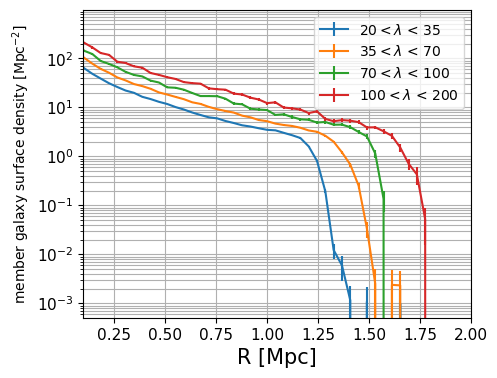

In [15]:
plt.figure(figsize=(5,4))
bin_radius = np.linspace(0.001, 2, 50)
bins = [[bin_radius[i],bin_radius[i+1]] for i in range(len(bin_radius)-1) ]
bin_center = np.mean(bins, axis=1)
Surface_per_bin = np.array([np.pi*(bin_[1]**2-bin_[0]**2) for bin_ in bins])
for j, richness_bin in enumerate(analysis.Obs_bin):
    res_stack = []
    for i, z_bin in enumerate(analysis.Z_bin):
        mask_clusters_in_bins = dat['richness'] > richness_bin[0]
        mask_clusters_in_bins &= dat['richness'] < richness_bin[1]
        mask_clusters_in_bins &= dat['redshift'] > z_bin[0]
        mask_clusters_in_bins &= dat['redshift'] < z_bin[1]
        id_cut = dat['cluster_id'][mask_clusters_in_bins]
        redshift_cut = dat['redshift'][mask_clusters_in_bins]
        ra_cut = dat['ra'][mask_clusters_in_bins]
        dec_cut = dat['dec'][mask_clusters_in_bins]
        for i in range(len(id_cut)):
            ra_source_ = dat['ra_member'][dat['cluster_id_member'] == id_cut[i]]
            dec_source_ = dat['dec_member'][dat['cluster_id_member'] == id_cut[i]]
            angsep, phi = _compute_lensing_angles_flatsky(ra_cut[i], dec_cut[i], ra_source_, dec_source_)
            d = cosmo.eval_da_z1z2(0, redshift_cut[i])
            dcenter = angsep * d
            bin_center, res = binned_count(bins, dcenter)
            res_stack.append(res)
    plt.errorbar(bin_center, np.mean(res_stack, axis=0)/Surface_per_bin, 
                 np.std(res_stack, axis=0)/(np.sqrt(len(res_stack))*Surface_per_bin), 
                 color = 'C'+str(j), label = f'${richness_bin[0]} < \lambda$ < {richness_bin[1]}')
plt.grid(which='both')
plt.xlim(0.1, 2)
plt.legend(fontsize=10)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('R [Mpc]', fontsize=15)
plt.ylabel(r'member galaxy surface density [Mpc$^{-2}$]', fontsize=10)